In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error



In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
class Encoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, encoding_dim)
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        return self.decoder(x)
    
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
# class ComplexLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
#         super(ComplexLSTMModel, self).__init__()
#         # LSTM Layer: Bidirectional for richer context
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
#                             batch_first=True, dropout=dropout_rate, 
#                             bidirectional=True)
#         # Fully connected layers for added complexity
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM doubles hidden size
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size // 2, 1)

#     def forward(self, x):
#         # LSTM expects input of shape (batch_size, sequence_length, input_size)
#         out, _ = self.lstm(x)
#         # Use the output of the last time step
#         out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
#         out = self.fc1(out)  # First fully connected layer
#         out = self.dropout1(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc2(out)  # Second fully connected layer
#         out = self.dropout2(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc3(out)  # Output layer
#         return out


class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # Unidirectional LSTM for sequential stock price prediction
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout_rate)  # Removed bidirectional=True
        
        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = torch.relu(self.fc1(out))  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))  # Second fully connected layer
        out = self.dropout2(out)
        out = self.fc3(out)  # Output layer (no activation for regression)
        return out

In [17]:
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 9

In [18]:
df = pd.read_csv('SPY.csv')
df.shape

(8020, 11)

<span style="color: yellow; font-size: 40px;">Original LSTM</span>

In [19]:
# Convert the "Date" column to datetime
df["Date"] = pd.to_datetime(df["Date"], format='%Y/%m/%d')

# Sort the data by date in ascending order
df = df.sort_values(by="Date")

# Get the earliest and latest dates
earliest_date = df["Date"].min()
latest_date = df["Date"].max()

print("Earliest Date:", earliest_date)
print("Latest Date:", latest_date)

Earliest Date: 1993-01-29 00:00:00
Latest Date: 2024-12-04 00:00:00


In [20]:
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)

df = df.dropna()


In [21]:
dates = df["Date"]
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

In [22]:
feature_columns = ["Open", "High", "Low", "Close", "Volume"]  

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[feature_columns]), columns=feature_columns, index=X.index)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [23]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [24]:
# Hyperparameters
# input_size = X_train.shape[2]  # Number of features
# hidden_size = 32
# num_layers = 2
# dropout_rate = 0.3
# learning_rate = 0.01
# num_epochs = 100
# patience = 10

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 64
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.001
num_epochs = 100
patience = 20

# Initialize the LSTM model
# model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)
original_lstm = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)

# LSTM_model_file = './lstm_trials/lstm_uni.pth'
LSTM_model_file = './lstm_trials/lstm_after_gridsearch.pth'

original_lstm.load_state_dict(torch.load(LSTM_model_file))

# criterion = nn.MSELoss()

# original_lstm.eval()
# test_loss = 0.0
# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         outputs = original_lstm(X_batch)
#         loss = criterion(outputs, y_batch)
#         test_loss += loss.item() * X_batch.size(0)

# test_loss /= len(test_loader.dataset)
# print(f'Test Loss: {test_loss:.4f}')

# # Calculate Mean Absolute Error (MAE)
# test_mae = 0.0
# with torch.no_grad():
#     for X_batch, y_batch in test_loader:
#         outputs = original_lstm(X_batch)
#         mae = torch.mean(torch.abs(outputs - y_batch))
#         test_mae += mae.item() * X_batch.size(0)

# test_mae /= len(test_loader.dataset)
# print(f'Test MAE: {test_mae:.4f}')

original_lstm.eval()

X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32)
outputs = original_lstm(X_seq_tensor)



C:\Users\ROG\AppData\Local\Temp/ipykernel_26320/258380665.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_lstm.load_state_dict(torch.load(LSTM_model_file))


In [25]:
error = 0
largest_error = 0
less_than_actual = 0
more_than_actual = 0

for true, pred in zip(y_seq, outputs):
    percent = abs(true - pred) / true
    if percent > largest_error:
        largest_error = percent
    error += percent
    if pred < true:
        less_than_actual += 1
    else:
        more_than_actual += 1
error = error / len(y_seq)
error = error.item()
largest_error = largest_error.item()
print(f"Average error percentage: {error*100}")
print(f"Largest error percentage: {largest_error*100}")
print(f"Less than actual: {less_than_actual}")
print(f"More than actual: {more_than_actual}")


Average error percentage: 2.5766585022211075
Largest error percentage: 22.331877052783966
Less than actual: 5045
More than actual: 2965


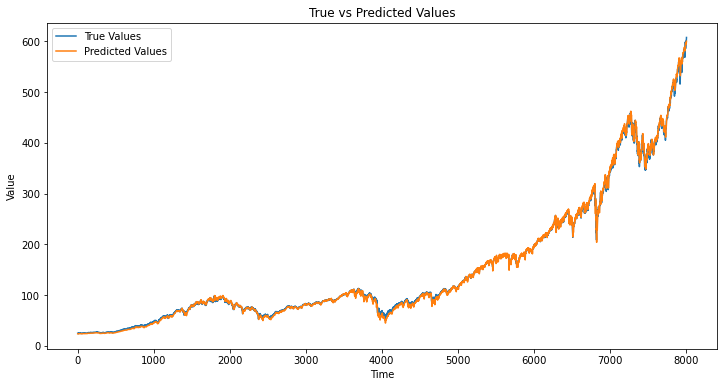

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(y_seq, label='True Values')
plt.plot(outputs.detach().numpy(), label='Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

<span style="color: yellow; font-size: 40px;">Autoencoder</span>

In [27]:
X = df

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[feature_columns]), columns=feature_columns, index=X.index)

In [28]:
X_train_val, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.25, random_state=42)

In [29]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values
X_scaled = X_scaled.values

In [30]:
input_dim = X_train.shape[1]
encoding_dim = 8

In [31]:
encoder_model_file = './models/encoder.pth'
decoder_model_file = './models/decoder.pth'

In [32]:
if os.path.exists(encoder_model_file) and os.path.exists(decoder_model_file):
    print("Loading existing models...")
    encoder = Encoder(input_dim, encoding_dim).to(device)
    decoder = Decoder(encoding_dim, input_dim).to(device)
    encoder.load_state_dict(torch.load(encoder_model_file))
    decoder.load_state_dict(torch.load(decoder_model_file))
else:
    print("Some models are missing")
    

Loading existing models...


C:\Users\ROG\AppData\Local\Temp/ipykernel_26320/3102932148.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(encoder_model_file))
C:\Use

In [33]:
autoencoder = Autoencoder(encoder, decoder).to(device)
autoencoder.eval()

Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=5, out_features=128, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=64, out_features=8, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=64, out_features=128, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.2, inplace=False)
      (6): Linear(in_features=128, out_features=5, bias=True)
    )
  )
)

In [34]:
# Calculate reconstruction error on the train set
with torch.no_grad():
    reconstructed_test = autoencoder(torch.tensor(X_scaled, dtype=torch.float32).to(device)).cpu().numpy()

# Calculate Mean Squared Error (MSE)
mse = np.mean((X_scaled - reconstructed_test) ** 2)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(X_scaled - reconstructed_test))
print(f'Mean Absolute Error (MAE): {mae}')

reconstruction_error_percentage = (
    np.mean(np.abs(X_scaled - reconstructed_test) / (np.abs(X_scaled) + 1e-8), axis=1) * 100
)
reconstruction_error_percentage_mean = np.mean(reconstruction_error_percentage)
print(f'Reconstruction Error Percentage: {reconstruction_error_percentage_mean}')

def calculate_index_error_percentage(index, X, reconstructed_X):
    print(np.mean(np.abs(X[index] - reconstructed_X[index]) / (np.abs(X[index]) + 1e-8)) * 100)

Mean Squared Error (MSE): 0.000393898925208361
Mean Absolute Error (MAE): 0.013584979295197346
Reconstruction Error Percentage: 7.316429470988849


In [35]:
print("Number of data points with reconstruction error percentage greater than the mean:", np.sum(reconstruction_error_percentage > reconstruction_error_percentage_mean))

Number of data points with reconstruction error percentage greater than the mean: 989


<span style="color: yellow; font-size: 40px;">Improving the LSTM using the autoencoder</span>

In [36]:
import torch.nn.functional as F

In [37]:
# Ensure outputs is detached from the computation graph and converted to numpy
predicted_values = outputs.detach().numpy()

predicted_values.shape

(8010, 1)

In [38]:
# df['predictions'] = np.nan

# # Assign the predicted values starting at index 24
# df.loc[25:, 'predictions'] = predicted_values

In [39]:
# convert reconstruction percentage to a separate dataframe
new_df = pd.DataFrame(reconstruction_error_percentage, columns=['reconstruction_error_percentage'], index=df.index)

In [40]:
new_df['target'] = df['Target']

new_df['predictions'] = np.nan
new_df.loc[9:, 'predictions'] = predicted_values

In [41]:
new_df = new_df.dropna()

In [42]:
new_df['bias'] = new_df['target'] - new_df['predictions']

In [43]:
class BiasPredictor(nn.Module):
    def __init__(self):
        super(BiasPredictor, self).__init__()
        self.fc1 = nn.Linear(1, 256)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc4 = nn.Linear(64, 32)
        self.dropout4 = nn.Dropout(0.3)
        
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 8)
        self.fc7 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        return self.fc7(x)

In [44]:
def train_bias_predictor(features, target_bias, val_features, val_target_bias, epochs=1000, learning_rate=0.0001, patience=10):
    model = BiasPredictor().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')  # Initialize the best validation loss
    patience_counter = 0  # Counter for early stopping
    best_model_state = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        predictions = model(features).squeeze()
        loss = criterion(predictions, target_bias)
        loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_predictions = model(val_features).squeeze()
            val_loss = criterion(val_predictions, val_target_bias)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()  # Save the best model state
        else:
            patience_counter += 1

        # Print progress
        # if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

        # Stop training if patience is exceeded
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
            break

    # Load the best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

In [45]:
# X = new_df['reconstruction_error_percentage'].values.reshape(-1, 1)
X = new_df
y = new_df['bias'].values

if 'reconstruction_error_percentage_array' not in X.columns:
    X['reconstruction_error_percentage_array'] = [[] for _ in range(len(X))]

    arr = []

    for i in range(len(X)):
        temp_array = []
        for j in range(9):
            temp_array.append(reconstruction_error_percentage[i+j+1])
        # X.at[i, 'reconstruction_error_percentage_array'] = temp_array
        arr.append(temp_array)

    X['reconstruction_error_percentage_array'] = arr

# train val test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [46]:
bias_predictor_path = './models/bias_predictor.pth'

# X_train X_val and X_test are the dataframes that contains other columns. In the actual training process we just 
# want to use the reconstruction error percentage column, hence we will extract that column and convert it to a tensor

if not os.path.exists(bias_predictor_path):
    bias_predictor = train_bias_predictor(torch.tensor(X_train['reconstruction_error_percentage'].values.reshape(-1,1), dtype=torch.float32).to(device), 
                                          torch.tensor(y_train, dtype=torch.float32).to(device),
                                          torch.tensor(X_val['reconstruction_error_percentage'].values.reshape(-1,1), dtype=torch.float32).to(device),
                                          torch.tensor(y_val, dtype=torch.float32).to(device),
                                          epochs=1000, learning_rate=0.0001, patience=30)
else:
    bias_predictor = BiasPredictor().to(device)
    bias_predictor.load_state_dict(torch.load(bias_predictor_path))

C:\Users\ROG\AppData\Local\Temp/ipykernel_26320/2873719968.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  bias_predictor.load_state_dict(torch.load(bias_predictor_path

In [47]:
new_df['prediction_error_percentage'] = np.nan
new_df['prediction_error_percentage'] = (abs(new_df['bias']) / new_df['target']) * 100

In [48]:
features = torch.tensor(X_test['reconstruction_error_percentage'].values.reshape(-1,1), dtype=torch.float32).to(device)
predictions = bias_predictor(features).squeeze().cpu().detach().numpy()
# get a dataframe with predictions and y_test
predictions_df = pd.DataFrame({'predictions': predictions, 'target': y_test})

In [49]:
new_df

,reconstruction_error_percentage,target,predictions,bias,reconstruction_error_percentage_array,prediction_error_percentage
9,0.888079,24.976170,24.021490,0.954679,"[0.8914554698822016, 0.8894131969174759, 0.892...",3.822361
10,0.885900,24.346083,24.042667,0.303415,"[0.8894131969174759, 0.8926279864160259, 0.891...",1.246259
11,0.890866,24.328583,24.039593,0.288990,"[0.8926279864160259, 0.8917197775553967, 0.888...",1.187862
12,0.890510,24.311090,23.921227,0.389864,"[0.8917197775553967, 0.8887546261209618, 0.887...",1.603647
13,0.895600,24.398588,23.752037,0.646551,"[0.8887546261209618, 0.8875140032785958, 0.886...",2.649953
...,...,...,...,...,...,...
8014,3.770355,598.830017,595.398499,3.431519,"[2.3713694567566943, 16.458029836360343, 2.276...",0.573037
8015,1.781509,602.549988,596.411682,6.138306,"[16.458029836360343, 2.2764292166983733, 4.542...",1.018721
8016,1.437670,603.630005,597.702881,5.927124,"[2.2764292166983733, 4.542149906403055, 4.2425...",0.981913
8017,1.594694,603.909973,598.967468,4.942505,"[4.542149906403055, 4.242525669273216, 3.79664...",0.818417


In [50]:
X_test['predicted_bias_with_one_input'] = np.nan
X_test['predicted_bias_with_one_input'] = predictions

In [51]:
X_test

,reconstruction_error_percentage,target,predictions,bias,reconstruction_error_percentage_array,predicted_bias_with_one_input
563,0.872467,30.429846,28.182663,2.247183,"[0.865808988877958, 0.8668465829545656, 0.8671...",-2.417470
6789,6.734052,307.836670,308.924255,-1.087585,"[10.185029277702128, 2.2025611446663187, 5.732...",-0.227217
3110,1.485681,82.987839,82.817764,0.170074,"[0.7517255375362865, 0.6664800255598702, 0.686...",-2.615610
7057,2.748172,369.807526,371.961212,-2.153687,"[1.3816415978691088, 4.0989117322815245, 0.985...",-1.453516
2614,0.990742,67.861076,65.243706,2.617371,"[1.2778963613711947, 0.7747250560136459, 1.508...",-2.497043
...,...,...,...,...,...,...
2964,1.913761,79.646431,76.761215,2.885216,"[0.6348746987879306, 0.5525179639740401, 1.215...",-2.187044
1975,1.169535,86.870735,88.112328,-1.241592,"[1.2430595625005405, 1.1607447280814434, 1.275...",-2.024758
6054,3.809520,205.387939,204.572617,0.815323,"[9.967309715008783, 4.466418914873627, 14.0424...",-1.132917
1088,0.645578,52.037102,49.502167,2.534935,"[0.6782854304440461, 0.656536332774514, 0.6494...",-1.865426


In [52]:
X_test['new_predictions_with_one_input'] = X_test['predictions'] + X_test['predicted_bias_with_one_input']

In [53]:
X_test['original_error_percentage'] = (abs(X_test['bias']) / X_test['target']) * 100
X_test['new_error_percentage_with_one_input'] = (abs(X_test['target'] - X_test['new_predictions_with_one_input']) / X_test['target']) * 100

In [54]:
X_test[['original_error_percentage', 'new_error_percentage_with_one_input']].describe()

,original_error_percentage,new_error_percentage_with_one_input
count,1602.000000,1602.000000
mean,2.530712,4.649052
std,2.374628,4.685974
min,0.000122,0.000587
25%,0.767609,1.060381
50%,1.662241,2.924778
75%,3.795965,6.535524
max,18.144303,21.099976


In [55]:
torch.save(bias_predictor.state_dict(), bias_predictor_path)

<span style="color: yellow; font-size: 40px;">BREAKERRRRRRRRR</span>

In [56]:
class BiasPredictor(nn.Module):
    def __init__(self):
        super(BiasPredictor, self).__init__()
        self.fc1 = nn.Linear(1, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        # self.dropout4 = nn.Dropout(0.3)
        
        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        # self.dropout5 = nn.Dropout(0.2)
        
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)
        self.fc8 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        # x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.fc5(x)))
        # x = self.dropout5(x)
        
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        return self.fc8(x)

In [57]:

error_one_input = []
std_one_input = []
max_error_one_input = []

for i in range(10):
    bias_predictor = train_bias_predictor(torch.tensor(X_train['reconstruction_error_percentage'].values.reshape(-1,1), dtype=torch.float32).to(device), 
                                          torch.tensor(y_train, dtype=torch.float32).to(device),
                                          torch.tensor(X_val['reconstruction_error_percentage'].values.reshape(-1,1), dtype=torch.float32).to(device),
                                          torch.tensor(y_val, dtype=torch.float32).to(device),
                                          epochs=1000, learning_rate=0.001, patience=40)
    features = torch.tensor(X_test['reconstruction_error_percentage'].values.reshape(-1,1), dtype=torch.float32).to(device)
    predictions = bias_predictor(features).squeeze().cpu().detach().numpy()
    
    X_test['predicted_bias_with_one_input'] = np.nan
    X_test['predicted_bias_with_one_input'] = predictions

    X_test['new_predictions_with_one_input'] = X_test['predictions'] + X_test['predicted_bias_with_one_input']
    X_test['new_error_percentage_with_one_input'] = (abs(X_test['target'] - X_test['new_predictions_with_one_input']) / X_test['target']) * 100
    avg_error = X_test['new_error_percentage_with_one_input'].mean()
    std_error = X_test['new_error_percentage_with_one_input'].std()
    max_error = X_test['new_error_percentage_with_one_input'].max()
    error_one_input.append(avg_error)
    std_one_input.append(std_error)
    max_error_one_input.append(max_error)


Epoch 1/1000, Loss: 16.9468, Val Loss: 17.2544
Epoch 2/1000, Loss: 16.9170, Val Loss: 17.2447
Epoch 3/1000, Loss: 16.8993, Val Loss: 17.2348
Epoch 4/1000, Loss: 16.8860, Val Loss: 17.2254
Epoch 5/1000, Loss: 16.8737, Val Loss: 17.2156
Epoch 6/1000, Loss: 16.8526, Val Loss: 17.2051
Epoch 7/1000, Loss: 16.8147, Val Loss: 17.1945
Epoch 8/1000, Loss: 16.8113, Val Loss: 17.1823
Epoch 9/1000, Loss: 16.7535, Val Loss: 17.1690
Epoch 10/1000, Loss: 16.7591, Val Loss: 17.1556
Epoch 11/1000, Loss: 16.7399, Val Loss: 17.1375
Epoch 12/1000, Loss: 16.7024, Val Loss: 17.1181
Epoch 13/1000, Loss: 16.7027, Val Loss: 17.0987
Epoch 14/1000, Loss: 16.6552, Val Loss: 17.0787
Epoch 15/1000, Loss: 16.6274, Val Loss: 17.0588
Epoch 16/1000, Loss: 16.6215, Val Loss: 17.0375
Epoch 17/1000, Loss: 16.5791, Val Loss: 17.0161
Epoch 18/1000, Loss: 16.5875, Val Loss: 16.9936
Epoch 19/1000, Loss: 16.5729, Val Loss: 16.9717
Epoch 20/1000, Loss: 16.5455, Val Loss: 16.9510
Epoch 21/1000, Loss: 16.5343, Val Loss: 16.9344
E

In [58]:
# if 'reconstruction_error_percentage_array' not in X.columns:
#     X['reconstruction_error_percentage_array'] = [[] for _ in range(len(X))]

#     arr = []

#     for i in range(len(X)):
#         temp_array = []
#         for j in range(9):
#             temp_array.append(reconstruction_error_percentage[i+j+1])
#         # X.at[i, 'reconstruction_error_percentage_array'] = temp_array
#         arr.append(temp_array)

#     X['reconstruction_error_percentage_array'] = arr
    

In [59]:
# # train val test split
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [60]:
# class BiasPredictor(nn.Module):
#     def __init__(self):
#         super(BiasPredictor, self).__init__()
#         self.fc1 = nn.Linear(9, 256)
#         self.dropout1 = nn.Dropout(0.3)
        
#         self.fc2 = nn.Linear(256, 128)
#         self.dropout2 = nn.Dropout(0.3)
        
#         self.fc3 = nn.Linear(128, 64)
#         self.dropout3 = nn.Dropout(0.3)
        
#         self.fc4 = nn.Linear(64, 32)
#         self.dropout4 = nn.Dropout(0.3)
        
#         self.fc5 = nn.Linear(32, 16)
#         self.fc6 = nn.Linear(16, 8)
#         self.fc7 = nn.Linear(8, 1)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
        
#         x = F.relu(self.fc2(x))
#         x = self.dropout2(x)
        
#         x = F.relu(self.fc3(x))
#         x = self.dropout3(x)
        
#         x = F.relu(self.fc4(x))
#         x = self.dropout4(x)
        
#         x = F.relu(self.fc5(x))
#         x = F.relu(self.fc6(x))
#         return self.fc7(x)

class BiasPredictor(nn.Module):
    def __init__(self):
        super(BiasPredictor, self).__init__()
        self.fc1 = nn.Linear(9, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        # self.dropout4 = nn.Dropout(0.3)
        
        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        # self.dropout5 = nn.Dropout(0.2)
        
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)
        self.fc8 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        # x = self.dropout4(x)
        
        x = F.relu(self.bn5(self.fc5(x)))
        # x = self.dropout5(x)
        
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        return self.fc8(x)


In [61]:
bias_predictor_path = './models/bias_predictor_new.pth'

# # X_train X_val and X_test are the dataframes that contains other columns. In the actual training process we just 
# # want to use the reconstruction error percentage column, hence we will extract that column and convert it to a tensor

# if not os.path.exists(bias_predictor_path):
#     bias_predictor = train_bias_predictor(torch.tensor(X_train['reconstruction_error_percentage'].values.reshape(-1,1), dtype=torch.float32).to(device), 
#                                           torch.tensor(y_train, dtype=torch.float32).to(device),
#                                           torch.tensor(X_val['reconstruction_error_percentage'].values.reshape(-1,1), dtype=torch.float32).to(device),
#                                           torch.tensor(y_val, dtype=torch.float32).to(device),
#                                           epochs=1000, learning_rate=0.0001, patience=30)
# else:
#     bias_predictor = BiasPredictor().to(device)
#     bias_predictor.load_state_dict(torch.load(bias_predictor_path))
    

# if not os.path.exists(bias_predictor_path):
#     bias_predictor = train_bias_predictor(
#         torch.tensor(
#             np.vstack(X_train['reconstruction_error_percentage_array'].values),  # Stack arrays into a 2D array
#             dtype=torch.float32
#         ).to(device),
#         torch.tensor(y_train, dtype=torch.float32).to(device),
#         torch.tensor(
#             np.vstack(X_val['reconstruction_error_percentage_array'].values),  # Stack arrays into a 2D array
#             dtype=torch.float32
#         ).to(device),
#         torch.tensor(y_val, dtype=torch.float32).to(device),
#         epochs=1000,
#         learning_rate=0.001,
#         patience=50
#     )
# else:
#     bias_predictor = BiasPredictor().to(device)
#     bias_predictor.load_state_dict(torch.load(bias_predictor_path))


In [62]:
# features = torch.tensor(np.vstack(X_test['reconstruction_error_percentage_array'].values), dtype=torch.float32).to(device)
# predictions = bias_predictor(features).squeeze().cpu().detach().numpy()

In [63]:
# predictions_df = pd.DataFrame({'predictions': predictions, 'target': y_test})

In [64]:
# where predictions and target have the same sign
# np.sum(np.sign(predictions) == np.sign(y_test))

In [65]:
# X_test['predicted_bias_with_array_input'] = np.nan
# X_test['predicted_bias_with_array_input'] = predictions

# X_test['new_predictions_with_array_input'] = X_test['predictions'] + X_test['predicted_bias_with_array_input']
# X_test['new_error_percentage_with_array_input'] = (abs(X_test['target'] - X_test['new_predictions_with_array_input']) / X_test['target']) * 100

In [66]:
# X_test[['original_error_percentage', 'new_error_percentage_with_one_input', 'new_error_percentage_with_array_input']].describe()

In [67]:
error_arr_input = []
std_arr_input = []
max_error_arr_input = []

for i in range(10):
    bias_predictor = train_bias_predictor(
        torch.tensor(
            np.vstack(X_train['reconstruction_error_percentage_array'].values),  # Stack arrays into a 2D array
            dtype=torch.float32
        ).to(device),
        torch.tensor(y_train, dtype=torch.float32).to(device),
        torch.tensor(
            np.vstack(X_val['reconstruction_error_percentage_array'].values),  # Stack arrays into a 2D array
            dtype=torch.float32
        ).to(device),
        torch.tensor(y_val, dtype=torch.float32).to(device),
        epochs=1000,
        learning_rate=0.001,
        patience=40
    )
    features = torch.tensor(np.vstack(X_test['reconstruction_error_percentage_array'].values), dtype=torch.float32).to(device)
    predictions = bias_predictor(features).squeeze().cpu().detach().numpy()

    X_test['predicted_bias_with_array_input'] = np.nan
    X_test['predicted_bias_with_array_input'] = predictions

    X_test['new_predictions_with_array_input'] = X_test['predictions'] + X_test['predicted_bias_with_array_input']
    X_test['new_error_percentage_with_array_input'] = (abs(X_test['target'] - X_test['new_predictions_with_array_input']) / X_test['target']) * 100
    avg_error = X_test['new_error_percentage_with_array_input'].mean()
    std_error = X_test['new_error_percentage_with_array_input'].std()
    max_error = X_test['new_error_percentage_with_array_input'].max()
    error_arr_input.append(avg_error)
    std_arr_input.append(std_error)
    max_error_arr_input.append(max_error)
    

Epoch 1/1000, Loss: 16.7120, Val Loss: 16.9217
Epoch 2/1000, Loss: 16.6897, Val Loss: 16.9177
Epoch 3/1000, Loss: 16.6696, Val Loss: 16.9134
Epoch 4/1000, Loss: 16.6572, Val Loss: 16.9092
Epoch 5/1000, Loss: 16.6330, Val Loss: 16.9045
Epoch 6/1000, Loss: 16.6154, Val Loss: 16.8989
Epoch 7/1000, Loss: 16.5991, Val Loss: 16.8931
Epoch 8/1000, Loss: 16.5826, Val Loss: 16.8862
Epoch 9/1000, Loss: 16.5630, Val Loss: 16.8785
Epoch 10/1000, Loss: 16.5519, Val Loss: 16.8712
Epoch 11/1000, Loss: 16.5079, Val Loss: 16.8640
Epoch 12/1000, Loss: 16.4856, Val Loss: 16.8543
Epoch 13/1000, Loss: 16.4653, Val Loss: 16.8419
Epoch 14/1000, Loss: 16.4044, Val Loss: 16.8278
Epoch 15/1000, Loss: 16.3803, Val Loss: 16.8139
Epoch 16/1000, Loss: 16.3462, Val Loss: 16.7973
Epoch 17/1000, Loss: 16.2913, Val Loss: 16.7765
Epoch 18/1000, Loss: 16.2731, Val Loss: 16.7543
Epoch 19/1000, Loss: 16.2203, Val Loss: 16.7282
Epoch 20/1000, Loss: 16.1714, Val Loss: 16.7001
Epoch 21/1000, Loss: 16.1321, Val Loss: 16.6700
E

In [68]:
combined_df = pd.DataFrame({'error_one_input': error_one_input, 'std_one_input': std_one_input, 'error_arr_input': error_arr_input, 'std_arr_input': std_arr_input})

In [69]:
combined_df

,error_one_input,std_one_input,error_arr_input,std_arr_input
0,2.188081,1.965631,1.775319,1.615696
1,2.217889,2.049757,1.757309,1.625015
2,2.178148,1.967640,1.844594,1.658586
3,2.189042,1.972966,1.794713,1.623295
4,2.160044,1.946068,1.787984,1.615875
5,2.205350,1.988628,1.784632,1.628415
6,2.242609,2.024037,1.749680,1.603995
7,2.247472,2.028750,1.809000,1.640362
8,2.141825,1.931153,1.820880,1.650240
9,2.227493,2.010775,1.766831,1.622973


In [70]:
combined_df.describe()

,error_one_input,std_one_input,error_arr_input,std_arr_input
count,10.000000,10.000000,10.000000,10.000000
mean,2.199795,1.988540,1.789094,1.628445
std,0.034791,0.038615,0.029418,0.016707
min,2.141825,1.931153,1.749680,1.603995
25%,2.180631,1.966133,1.768953,1.617650
50%,2.197196,1.980797,1.786308,1.624155
75%,2.225092,2.020721,1.805428,1.637376
max,2.247472,2.049757,1.844594,1.658586


In [71]:
X_test['original_error_percentage'].describe()

count    1602.000000
mean        2.530712
std         2.374628
min         0.000122
25%         0.767609
50%         1.662241
75%         3.795965
max        18.144303
Name: original_error_percentage, dtype: float64

In [72]:
X_test

,reconstruction_error_percentage,target,predictions,bias,reconstruction_error_percentage_array,predicted_bias_with_one_input,new_predictions_with_one_input,original_error_percentage,new_error_percentage_with_one_input,predicted_bias_with_array_input,new_predictions_with_array_input,new_error_percentage_with_array_input
563,0.872467,30.429846,28.182663,2.247183,"[0.865808988877958, 0.8668465829545656, 0.8671...",0.334249,28.516912,7.384799,6.286375,1.296565,29.479228,3.123966
6789,6.734052,307.836670,308.924255,-1.087585,"[10.185029277702128, 2.2025611446663187, 5.732...",-0.591945,308.332310,0.353300,0.161008,-0.630219,308.294036,0.148574
3110,1.485681,82.987839,82.817764,0.170074,"[0.7517255375362865, 0.6664800255598702, 0.686...",-0.038676,82.779089,0.204939,0.251543,1.086244,83.904008,1.103980
7057,2.748172,369.807526,371.961212,-2.153687,"[1.3816415978691088, 4.0989117322815245, 0.985...",0.574940,372.536152,0.582380,0.737850,-1.152370,370.808843,0.270767
2614,0.990742,67.861076,65.243706,2.617371,"[1.2778963613711947, 0.7747250560136459, 1.508...",0.140140,65.383846,3.856954,3.650444,1.253283,66.496989,2.010118
...,...,...,...,...,...,...,...,...,...,...,...,...
2964,1.913761,79.646431,76.761215,2.885216,"[0.6348746987879306, 0.5525179639740401, 1.215...",-0.037892,76.723323,3.622530,3.670105,0.222062,76.983277,3.343721
1975,1.169535,86.870735,88.112328,-1.241592,"[1.2430595625005405, 1.1607447280814434, 1.275...",-0.027142,88.085186,1.429241,1.397997,0.883410,88.995737,2.446166
6054,3.809520,205.387939,204.572617,0.815323,"[9.967309715008783, 4.466418914873627, 14.0424...",1.664630,206.237247,0.396967,0.413514,-1.189483,203.383133,0.976107
1088,0.645578,52.037102,49.502167,2.534935,"[0.6782854304440461, 0.656536332774514, 0.6494...",0.627546,50.129713,4.871399,3.665440,1.475862,50.978029,2.035226


In [73]:
# import shap
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# bias_predictor = BiasPredictor().to(device)

# X_reconstruction = np.stack(X_train['reconstruction_error_percentage_array'].values)
# y = y_train

# X_reconstruction_tensor = torch.tensor(X_reconstruction, dtype=torch.float32).to(device)
# y_tensor = torch.tensor(y, dtype=torch.float32)


# def model_wrapper(X):
#     X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
#     with torch.no_grad():
#         return bias_predictor(X_tensor).cpu().numpy()
    
    
# bias_predictor.eval()

# explainer = shap.KernelExplainer(model_wrapper, X_reconstruction_tensor[:750].cpu().numpy())

# shap_values = explainer.shap_values(X_reconstruction_tensor[:750].cpu().numpy())

# shap.summary_plot(shap_values, X_reconstruction_tensor[:750].cpu().numpy(), feature_names=[f"Day -{i}" for i in range(9, 0, -1)])

In [74]:
# shap_values_array = np.array(shap_values)

# # Reshape the 3D array to 2D
# shap_values_2d = shap_values_array.reshape(-1, shap_values_array.shape[-1])

# # Create the DataFrame
# shap_values_df = pd.DataFrame(shap_values_2d, columns=[f"Day -{i}" for i in range(9, 0, -1)])

In [75]:
# column_sums = shap_values_df.abs().sum(axis=0)
# relative_weightage = column_sums / column_sums.sum()
# print("Relative Weightage of Each Day:", relative_weightage)

In [76]:
# # print each relative weight separately
# for i, weight in enumerate(relative_weightage):
#     print(f"Day -{i+1}:", weight)

In [77]:
# if weights is None:
#     weights = []
#     for weight in relative_weightage:
#         weights.append(weight)

In [78]:
weights = [0.10619458980191179,
 0.032590702943947676,
 0.24322533687632794,
 0.04211258336931392,
 0.11436472610842367,
 0.12440656192592138,
 0.14868789216363856,
 0.10144880432373195,
 0.08696880248678329]

In [79]:
if 'reconstruction_error_percentage_array_weighted' not in X_train.columns:
    X_train['reconstruction_error_percentage_array_weighted'] = X_train['reconstruction_error_percentage_array'].apply(lambda x: (np.array(x) * np.array(weights)).tolist())
    print("ran 1")

if 'reconstruction_error_percentage_array_weighted' not in X_val.columns:
    X_val['reconstruction_error_percentage_array_weighted'] = X_val['reconstruction_error_percentage_array'].apply(lambda x: (np.array(x) * np.array(weights)).tolist())
    print("ran 2")

if 'reconstruction_error_percentage_array_weighted' not in X_test.columns:
    X_test['reconstruction_error_percentage_array_weighted'] = X_test['reconstruction_error_percentage_array'].apply(lambda x: (np.array(x) * np.array(weights)).tolist())
    print("ran 3")



ran 1
ran 2
ran 3


In [80]:
error_arr_input_weighted = []
std_arr_input_weighted = []
max_error_arr_input_weighted = []

for i in range(10):
    bias_predictor = train_bias_predictor(
        torch.tensor(
            np.vstack(X_train['reconstruction_error_percentage_array_weighted'].values),  # Stack arrays into a 2D array
            dtype=torch.float32
        ).to(device),
        torch.tensor(y_train, dtype=torch.float32).to(device),
        torch.tensor(
            np.vstack(X_val['reconstruction_error_percentage_array_weighted'].values),  # Stack arrays into a 2D array
            dtype=torch.float32
        ).to(device),
        torch.tensor(y_val, dtype=torch.float32).to(device),
        epochs=1000,
        learning_rate=0.001,
        patience=40
    )
    features = torch.tensor(np.vstack(X_test['reconstruction_error_percentage_array_weighted'].values), dtype=torch.float32).to(device)
    predictions = bias_predictor(features).squeeze().cpu().detach().numpy()

    X_test['predicted_bias_with_array_input_weighted'] = np.nan
    X_test['predicted_bias_with_array_input_weighted'] = predictions

    X_test['new_predictions_with_array_input_weighted'] = X_test['predictions'] + X_test['predicted_bias_with_array_input_weighted']
    X_test['new_error_percentage_with_array_input_weighted'] = (abs(X_test['target'] - X_test['new_predictions_with_array_input_weighted']) / X_test['target']) * 100
    avg_error = X_test['new_error_percentage_with_array_input_weighted'].mean()
    std_error = X_test['new_error_percentage_with_array_input_weighted'].std()
    max_error = X_test['new_error_percentage_with_array_input_weighted'].max()
    error_arr_input_weighted.append(avg_error)
    std_arr_input_weighted.append(std_error)
    max_error_arr_input_weighted.append(max_error)
    

combined_df = pd.DataFrame({'error_one_input': error_one_input, 'std_one_input': std_one_input, 'error_arr_input': error_arr_input, 'std_arr_input': std_arr_input, 'error_arr_input_weighted': error_arr_input_weighted, 'std_arr_input_weighted': std_arr_input_weighted})
    

Epoch 1/1000, Loss: 16.8087, Val Loss: 17.0647
Epoch 2/1000, Loss: 16.7836, Val Loss: 17.0608
Epoch 3/1000, Loss: 16.7607, Val Loss: 17.0571
Epoch 4/1000, Loss: 16.7434, Val Loss: 17.0533
Epoch 5/1000, Loss: 16.7251, Val Loss: 17.0493
Epoch 6/1000, Loss: 16.7113, Val Loss: 17.0451
Epoch 7/1000, Loss: 16.6886, Val Loss: 17.0403
Epoch 8/1000, Loss: 16.6679, Val Loss: 17.0349
Epoch 9/1000, Loss: 16.6477, Val Loss: 17.0288
Epoch 10/1000, Loss: 16.6257, Val Loss: 17.0211
Epoch 11/1000, Loss: 16.5989, Val Loss: 17.0120
Epoch 12/1000, Loss: 16.5521, Val Loss: 17.0017
Epoch 13/1000, Loss: 16.5280, Val Loss: 16.9898
Epoch 14/1000, Loss: 16.5119, Val Loss: 16.9759
Epoch 15/1000, Loss: 16.4878, Val Loss: 16.9594
Epoch 16/1000, Loss: 16.4436, Val Loss: 16.9410
Epoch 17/1000, Loss: 16.4230, Val Loss: 16.9194
Epoch 18/1000, Loss: 16.3870, Val Loss: 16.8972
Epoch 19/1000, Loss: 16.3671, Val Loss: 16.8739
Epoch 20/1000, Loss: 16.3416, Val Loss: 16.8517
Epoch 21/1000, Loss: 16.2954, Val Loss: 16.8241
E

In [81]:
combined_df.describe()

,error_one_input,std_one_input,error_arr_input,std_arr_input,error_arr_input_weighted,std_arr_input_weighted
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,2.199795,1.988540,1.789094,1.628445,1.767203,1.617722
std,0.034791,0.038615,0.029418,0.016707,0.031655,0.026536
min,2.141825,1.931153,1.749680,1.603995,1.720592,1.580207
25%,2.180631,1.966133,1.768953,1.617650,1.748274,1.594662
50%,2.197196,1.980797,1.786308,1.624155,1.769321,1.622635
75%,2.225092,2.020721,1.805428,1.637376,1.784392,1.630596
max,2.247472,2.049757,1.844594,1.658586,1.825230,1.659043


In [82]:
max_df = pd.DataFrame({'max_error_one_input': max_error_one_input, 'max_error_arr_input': max_error_arr_input, 'max_error_arr_input_weighted': max_error_arr_input_weighted})
max_df.describe()

,max_error_one_input,max_error_arr_input,max_error_arr_input_weighted
count,10.000000,10.000000,10.000000
mean,17.670249,13.467119,13.401450
std,0.188573,0.632626,0.298046
min,17.435174,12.884786,13.038387
25%,17.553108,13.219586,13.151782
50%,17.626296,13.280163,13.334987
75%,17.787869,13.570499,13.628608
max,18.043797,15.097001,13.827979
